---
title: Balance sheet filter
space: INTFEL
parent: Yihan ZHONG
comment: Filtering the balance sheet news from the whole dataset, as these financial results lack relevance and do not contribute to the overall sentiment evaluation
---

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
import pandas as pd
from pathlib import Path
import pandas as pd 
import numpy as np 
import re
import seaborn as sns
import matplotlib.pyplot as plt

/home/yzhong/conda/envs/yihan_gpu/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# 0. Data loading

In [6]:
path = Path('/mnt/research-live/equity/reference/equity_data/sa_research/current/')
ead_ = pd.read_parquet(path /'CFM_AMER/equity_data/eqt_earning_announcement_dates.parquet') # date for earnings
news_company=pd.read_parquet('/mnt/research-live/user/yzhong/bloomberg_news_english_single_stock.parquet') # all single stock news

Creat dataframe that only contains news on earning days

In [7]:
news_company['date']=pd.to_datetime(news_company['date'])
#filtered_df contains news articles specifically associated with earning days
filtered_df = news_company.merge(ead_, left_on=['eqt_code', 'date'], right_on=['eqt_code', 'earning_date'], how='inner')

# 1. Regex expression for filtering balance sheet

## A. Observation

The key words was found by 
1. manual observation
2. Word counts

In [ ]:
import nltk
import wordcloud
from collections import Counter
def top_common_words(earning_no_capital,col,most_common):
    
    '''
    Function for getting the most common key words in the headline
    Arguments: 
    earning_no_capital: dataframe
    col: 'headline' or 'body'
    most_common: int --> number of the top most key words that you want to print
    
    Return:
    A list of tuples contains key words and its frequency
    
    '''
    # Get the stop words
    stopwords = set(wordcloud.STOPWORDS)
    # Create a list to store the words
    words = []
    if col=='body':
        df=earning_no_capital[~earning_no_capital['body'].apply(is_blank_string)]['body']
    if col=='headline':
        df=earning_no_capital['headline'].dropna()

    for text in df:
        tokens = nltk.word_tokenize(text.lower())
        # Filter out stop words and non-alphabetic words
        words += [word for word in tokens if word.isalpha() and word not in stopwords]

    # Count the frequency of words
    word_counts = Counter(words)

    # Get the top 10 most frequent words
    top_words = word_counts.most_common(most_common)

    # Print the top 10 words and their frequencies
    for word, count in top_words:
        print(f"{word}: {count}")
        
    return top_words

## B. Patterns

The patterns are: 
1. Headline that contains key words and digits
2. Headline that has no other digits surrounded by Q rather than 1, 2, 3, 4
3. Headline that only contains digits from year 1999-9999

In [9]:
def filter_balance_sheet(df, col='headline'):
    
    # Define the key words for filtering balance sheet news
    pattern = r"(?=.*?\b(?:CAPEX|CAPITAL|EPS|NET|INCOME|REV|INC|LOSS|BILLINGS|ADJ|SALES|EQUITY|ENTITLEMENT|COSTS|REVENUE|ADJUSTED|PROFIT|EST|EARNINGS|INCOME|CASH|EPA)\b)"

    # Apply filter conditions and add flag column
    df['balance_sheet'] = (
        df[col].apply(lambda headline: bool(re.search(pattern, headline))) # Check if headline contains the key words,(True if there is a match, False otherwise).
        #excluded headlines that contains only 1Q, 2Q, 3Q, 4Q but no other digits number surrended by Q 
        & ~df[col].apply(lambda headline: bool(re.match(r"^\D*\b\dQ\b\D*$", headline)))
        # exclude headlines that only contains year and no other digits number surronded  year range (1999-9999)
        & ~df[col].apply(lambda headline: bool(re.match(r"^\D*(?:(19|[2-9][0-9])\d{2})\D*$", headline)))
        #make sure that the sentence contains digit
        & df[col].str.contains(r'\d') 
    ).astype(int)

    return df

## C. Results

### Results on earning days

In [10]:
df=filter_balance_sheet(filtered_df, col='headline')

In [21]:
df

,suid,last_update,eqt_code,analyst,date,daclose,headline,body,earning_date,balance_sheet
0,K9QU086JIJUO,2008-11-03 06:00:08.530,TRL_UN,False,2008-11-03,2008-11-03,DAVITA 3Q EPS 89C.,PR Newswire: U.S. press release is accessible ...,2008-11-03,1
1,K9QU3P0D9L4G,2008-11-03 06:02:13.890,TRL_UN,False,2008-11-03,2008-11-03,DAVITA 3Q NET $93.9 MLN.,PR Newswire: U.S. press release is accessible ...,2008-11-03,1
2,K9QU4U0D9L3Q,2008-11-03 06:02:54.570,TRL_UN,False,2008-11-03,2008-11-03,DAVITA SEES 2008 OP. PROFIT NEAR MIDDLE OF PRE...,PR Newswire: U.S. press release is accessible ...,2008-11-03,0
3,K9QV121A1I4I,2008-11-03 06:22:14.950,TRL_UN,False,2008-11-03,2008-11-03,DaVita Profit Falls After One-Time Gains in Qu...,"DaVita Inc., the second-largest U.S.operator o...",2008-11-03,0
4,K9RQLO1A74E9,2008-11-03 17:44:12.690,TRL_UN,False,2008-11-03,2008-11-03,DaVita Profit Falls After One-Time Gain Year E...,Adds analysts' estimates in the second paragra...,2008-11-03,0
...,...,...,...,...,...,...,...,...,...,...
725420,RU5LRT6RV5E3,2023-05-04 21:45:29.952,BRPR3_BS,False,2023-05-04,2023-05-04,"BR PROPERTIES 1Q ADJ. EBITDA R$13.1M, -76% Y/Y.",,2023-05-04,1
725421,RU5MG06RV5E8,2023-05-04 22:00:00.601,SIMO_US,False,2023-05-04,2023-05-04,"SILICON MOTION 1Q ADJ EARNINGS PER ADS 33C, ES...",,2023-05-04,1
725422,RU5MG06RV5E9,2023-05-04 22:00:00.615,SIMO_US,False,2023-05-04,2023-05-04,"SILICON MOTION 1Q REV. $124.1M, EST. $167.6M.",,2023-05-04,1
725423,RU5MG16RV5DS,2023-05-04 22:00:02.824,SIMO_US,False,2023-05-04,2023-05-04,Silicon Motion 1Q Adj Earnings per ADS Misses ...,Silicon Motion reported adjusted earningsper A...,2023-05-04,0


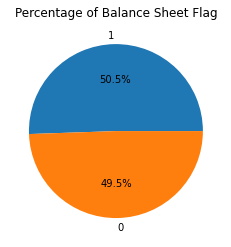

In [19]:
def plot_balance_sheet(df):
    # Calculate the percentage of balance_sheet values
    percentages = df['balance_sheet'].value_counts(normalize=True) * 100

    # Create the pie plot
    labels =  percentages.index
    plt.pie(percentages, labels=labels, autopct='%1.1f%%')

    # Add title
    plt.title('Percentage of Balance Sheet Flag')

    # Show the plot
    plt.show()

# Example usage
plot_balance_sheet(df)

### Results on all the headlines

In [16]:
df2=filter_balance_sheet(news_company, col='headline')

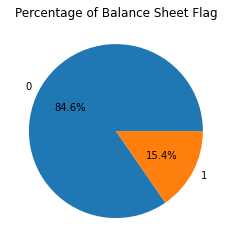

In [20]:
plot_balance_sheet(df2)